### Time Series Anomaly Detection using Artifical Neural Network

#### Introduction

In [50]:
# Import packages
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from matplotlib import pyplot as plt

https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv
https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv


In [51]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_no_anomaly = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_anomaly = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")

In [52]:
df_no_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [53]:
df_daily_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


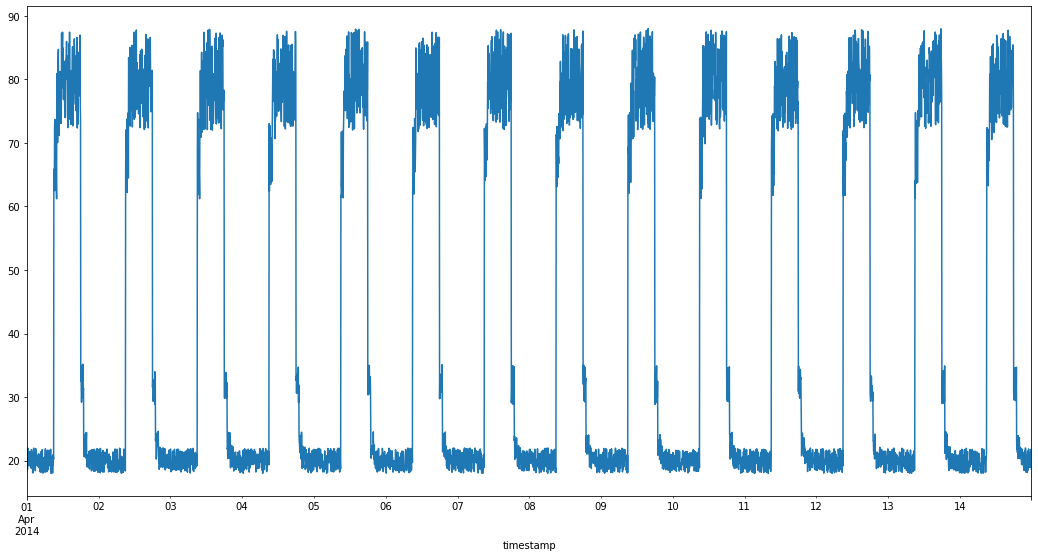

In [54]:
#Have a look at the plot of the small noise file.
fig, ax = plt.subplots(figsize=(18,9))
df_no_anomaly.plot(legend=False, ax=ax);

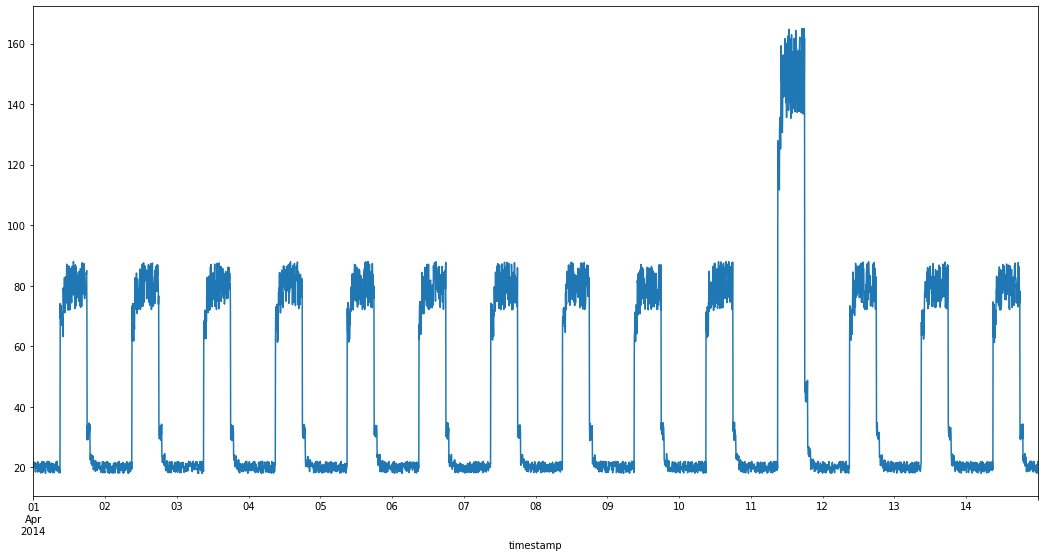

In [55]:
#Have a look at the plot of the small noise file with the anomaly.
fig, ax = plt.subplots(figsize=(18,9))
df_daily_anomaly.plot(legend=False, ax=ax);

### Preprocessing

In [56]:
# Normalize and save the mean and std.
#Variable for the mean of the small noise data set
training_mean = df_no_anomaly.mean()

#Variable for the std deviation of the small noise data set
training_std = df_no_anomaly.std()

#Calculate the training value(small noise value - mean/std deviation)
df_training_value = (df_no_anomaly - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [57]:
training_mean

value    42.438353
dtype: float64

In [58]:
training_std

value    28.077122
dtype: float64

In [59]:
df_training_value

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


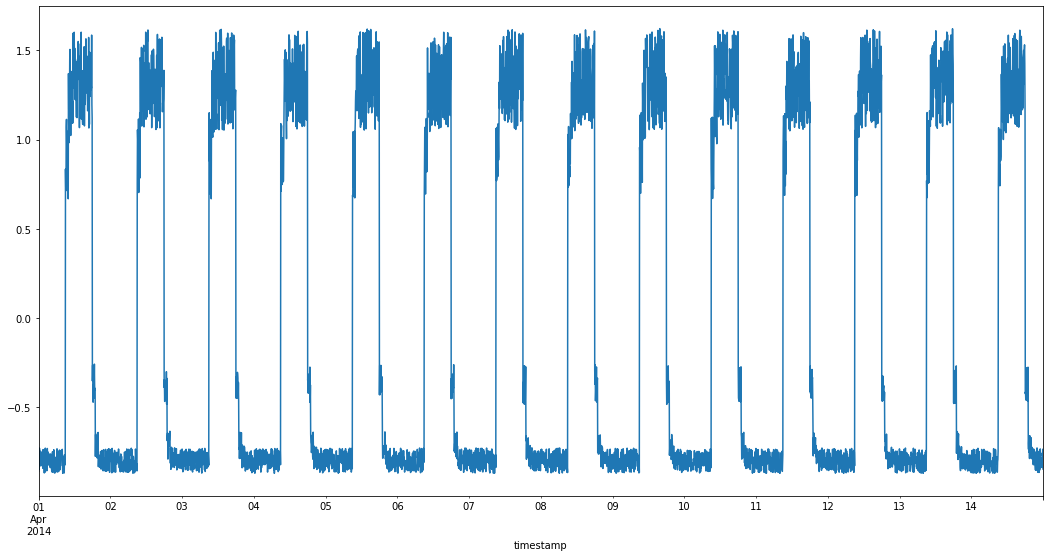

In [60]:
#Have a look at the training data. 
fig, ax = plt.subplots(figsize=(18,9))
df_training_value.plot(legend=False, ax=ax);


In [61]:
time_steps = 288

# Generated training sequences for use in the model.
def create_windows(values, time_steps=time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_windows(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [62]:
x_train

array([[[-0.85882857],
        [-0.72899302],
        [-0.84814772],
        ...,
        [-0.86453747],
        [-0.81250829],
        [-0.79671155]],

       [[-0.72899302],
        [-0.84814772],
        [-0.72958579],
        ...,
        [-0.81250829],
        [-0.79671155],
        [-0.78767946]],

       [[-0.84814772],
        [-0.72958579],
        [-0.731173  ],
        ...,
        [-0.79671155],
        [-0.78767946],
        [-0.73706287]],

       ...,

       [[-0.8226548 ],
        [-0.86660975],
        [-0.82181363],
        ...,
        [-0.79164661],
        [-0.78025492],
        [-0.83364049]],

       [[-0.86660975],
        [-0.82181363],
        [-0.75595835],
        ...,
        [-0.78025492],
        [-0.83364049],
        [-0.73510213]],

       [[-0.82181363],
        [-0.75595835],
        [-0.74256753],
        ...,
        [-0.83364049],
        [-0.73510213],
        [-0.8460886 ]]])

In [63]:
#Redo the  the layers, and add in comments on what they are.
#Figure out what they all mean.

layers = []

In [64]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        keras.layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_7 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_10 (Conv1DT (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_11 (Conv1DT (None, 288, 1)           

In [65]:
# Explain what this is, model.fit
#https://keras.io/api/models/model_training_apis/
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 105ms/step - loss: 0.5354 - val_loss: 0.0717
Epoch 2/50
27/27 [==============================] - 2s 92ms/step - loss: 0.0789 - val_loss: 0.0412
Epoch 3/50
27/27 [==============================] - 3s 117ms/step - loss: 0.0570 - val_loss: 0.0358
Epoch 4/50
27/27 [==============================] - 3s 127ms/step - loss: 0.0482 - val_loss: 0.0308
Epoch 5/50
27/27 [==============================] - 3s 117ms/step - loss: 0.0418 - val_loss: 0.0278
Epoch 6/50
27/27 [==============================] - 3s 94ms/step - loss: 0.0373 - val_loss: 0.0275
Epoch 7/50
27/27 [==============================] - 3s 110ms/step - loss: 0.0337 - val_loss: 0.0249
Epoch 8/50
27/27 [==============================] - 3s 118ms/step - loss: 0.0306 - val_loss: 0.0220
Epoch 9/50
27/27 [==============================] - 4s 132ms/step - loss: 0.0282 - val_loss: 0.0222
Epoch 10/50
27/27 [==============================] - 3s 126ms/step - loss: 0.0262 - val_loss: 0.0210
E

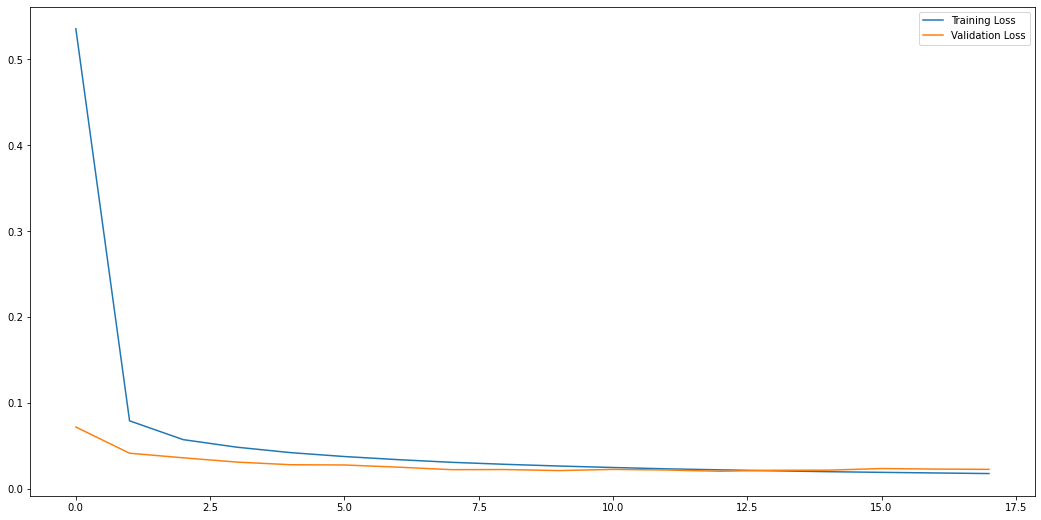

In [66]:
plt.figure(figsize=(18,9))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

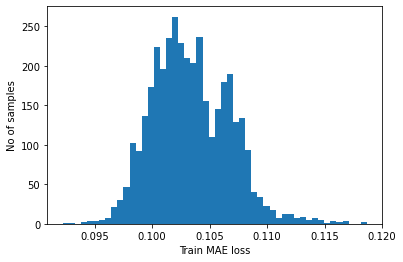

Reconstruction error threshold:  0.11868335293752658


In [67]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

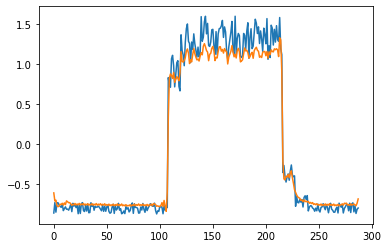

In [68]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

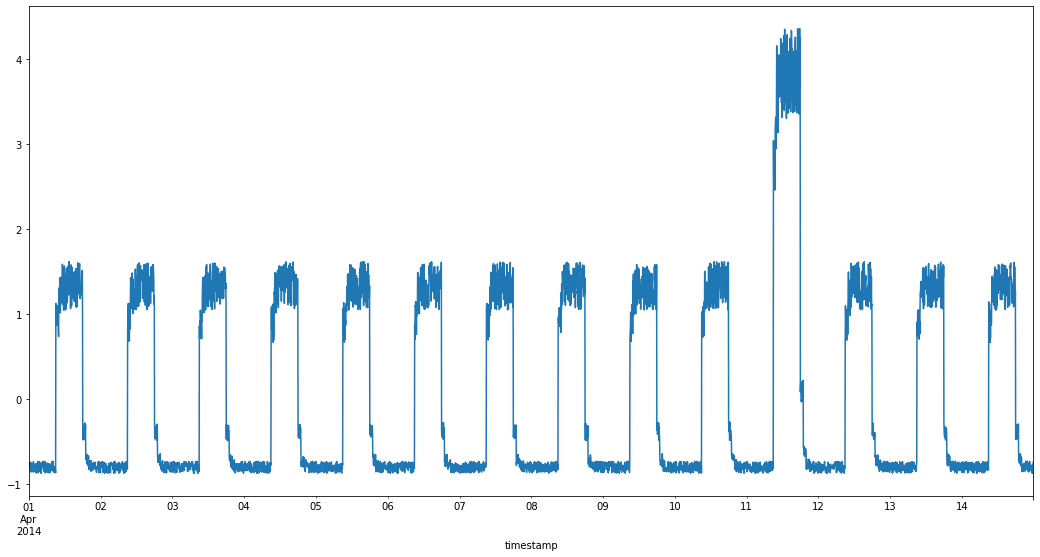

Test input shape:  (3745, 288, 1)


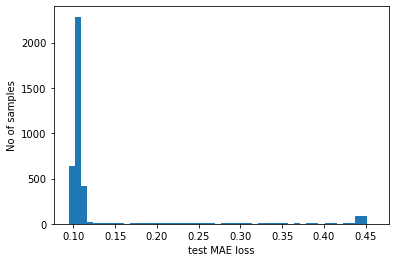

Number of anomaly samples:  398
Indices of anomaly samples:  (array([ 789, 1653, 1658, 2517, 2702, 2703, 2704, 2705, 2706, 2707, 2708,
       2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719,
       2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730,
       2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741,
       2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752,
       2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763,
       2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774,
       2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785,
       2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796,
       2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807,
       2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818,
       2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829,
       2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2

In [69]:
df_test_value = (df_daily_anomaly - training_mean) / training_std
fig, ax = plt.subplots(figsize=(18,9))
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_windows(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [70]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

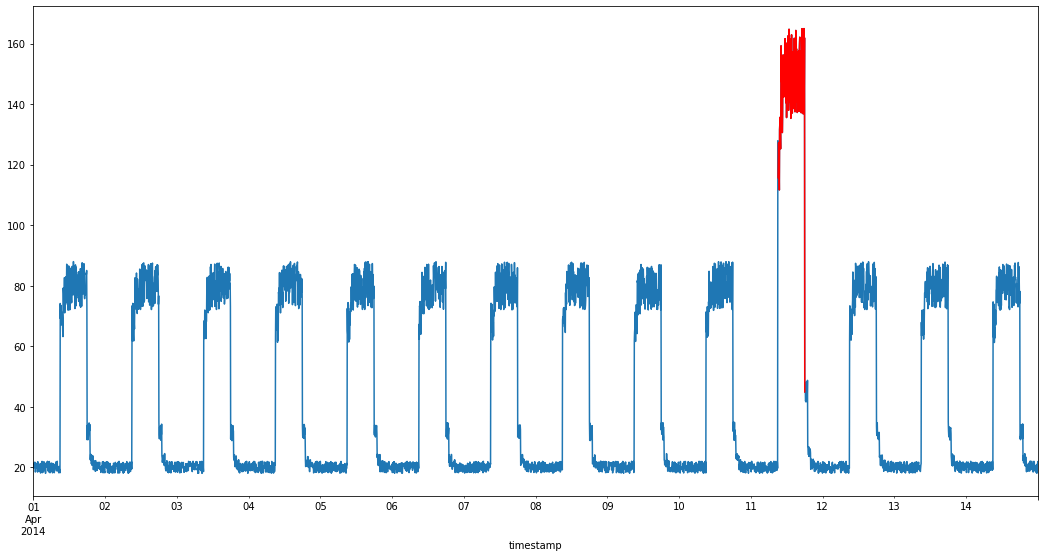

In [71]:
df_subset = df_daily_anomaly.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(18,9))
df_daily_anomaly.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show;